# Introdução

O artigo [GenAI with Python: RAG with LLM (Complete Tutorial)](https://towardsdatascience.com/genai-with-python-rag-with-llm-complete-tutorial-c276dda6707b) é um guia para a implementação de um sistema de Recuperação-Generativa Aumentada (RAG) utilizando Modelos de Linguagem de Grande Escala (LLMs) executados localmente com a ferramenta Ollama. O tutorial explora o uso do Ollama com diferentes modelos, como o phi3 e LLaVA, além de abordar o preprocessamento de dados a partir de arquivos PDF e a criação de um sistema de chat com capacidades RAG, utilizando o Streamlit e o ChromaDB.

A técnica de RAG permite que um usuário faça prompts a um LLM e receba respostas baseadas em documentos específicos. Para ilustrar esse processo, o autor utiliza um relatório anual da Nvidia Corporation para o ano fiscal de 2024 como exemplo, mostrando as etapas necessárias para alimentar um banco de dados vetorial com informações desse documento e, em seguida, criar um aplicativo de chat alimentado por LLM. Isso possibilita que o usuário faça perguntas detalhadas sobre o documento e obtenha respostas precisas e contextualizadas.


---

Devido a algumas peculiaridades da plataforma Google Colab, foram necessarias adições de algumas seções de código para possibilitar executar o código na forma de um notebook na nuvem. Essas seções estão marcadas por parenteses no titulo.

Os artigos utilizados como base para essa tarefa foram os [Running Ollama on Google Colab (Free Tier): A Step-by-Step Guide](https://pub.towardsai.net/running-ollama-on-google-colab-free-tier-a-step-by-step-guide-9ef74b1f8f7a) e o [How to Launch Streamlit App from Google Colab Notebook](https://discuss.streamlit.io/t/how-to-launch-streamlit-app-from-google-colab-notebook/42399)

No entanto, as capacidades de computação do sistema ofertado, com possibilidade de utilizar GPUs e TPUs para processamento, são mais do que suficientes para rodar os modelos mais leves do Ollama. Ainda é possível rodar os modelos utilizando a versão free e processamento por CPU, apesar da extrema demora para o modelo gerar as repostas. Dificuldades são apenas encontradas em questões da interface oferecida, com as vezes sendo necessarias utilizar o terminal do sistema.

# (CONFIGURAÇÃO)

Essa seção instala os pacotes descritos no artigo, juntamente com aqueles que foram necessários adicionar para usar o codigo no Colab

In [1]:
!pip install pdf2image #biblioteca para transformar PDFs em imagens
!pip install pytesseract #biblioteca para utilizar a ferramenta de OCR com o Python
!sudo apt install tesseract-ocr #ferramente de OCR
!apt-get install poppler-utils #ferramenta para manipular PDFs por meio da linha de comando
!pip install ollama #biblioteca para utilizar o Ollama atravez do Python
!pip install colab-xterm #biblioteca para permitir abrir uma sessão de terminal pelo notebook
!pip install chromadb #banco de dados de vetores
!pip install streamlit #biblioteca para criar interfaces para a aplicação
%load_ext colabxterm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,934 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

# (Download do arquivo PDF utilizado)


In [ ]:
import requests

with open("doc_nvidia.pdf", 'wb') as file:
  file.write(requests.get("https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/1cbe8fe7-e08a-46e3-8dcc-b429fc06c1a4.pdf").content)
  file.close()

# Extração de Texto de um arquivo PDF

O autor começa utilizando OCR para extrair o texto de um arquivo PDF.
Primeiro, cada pagina do arquivo é convertida para um arquivo de imagem.

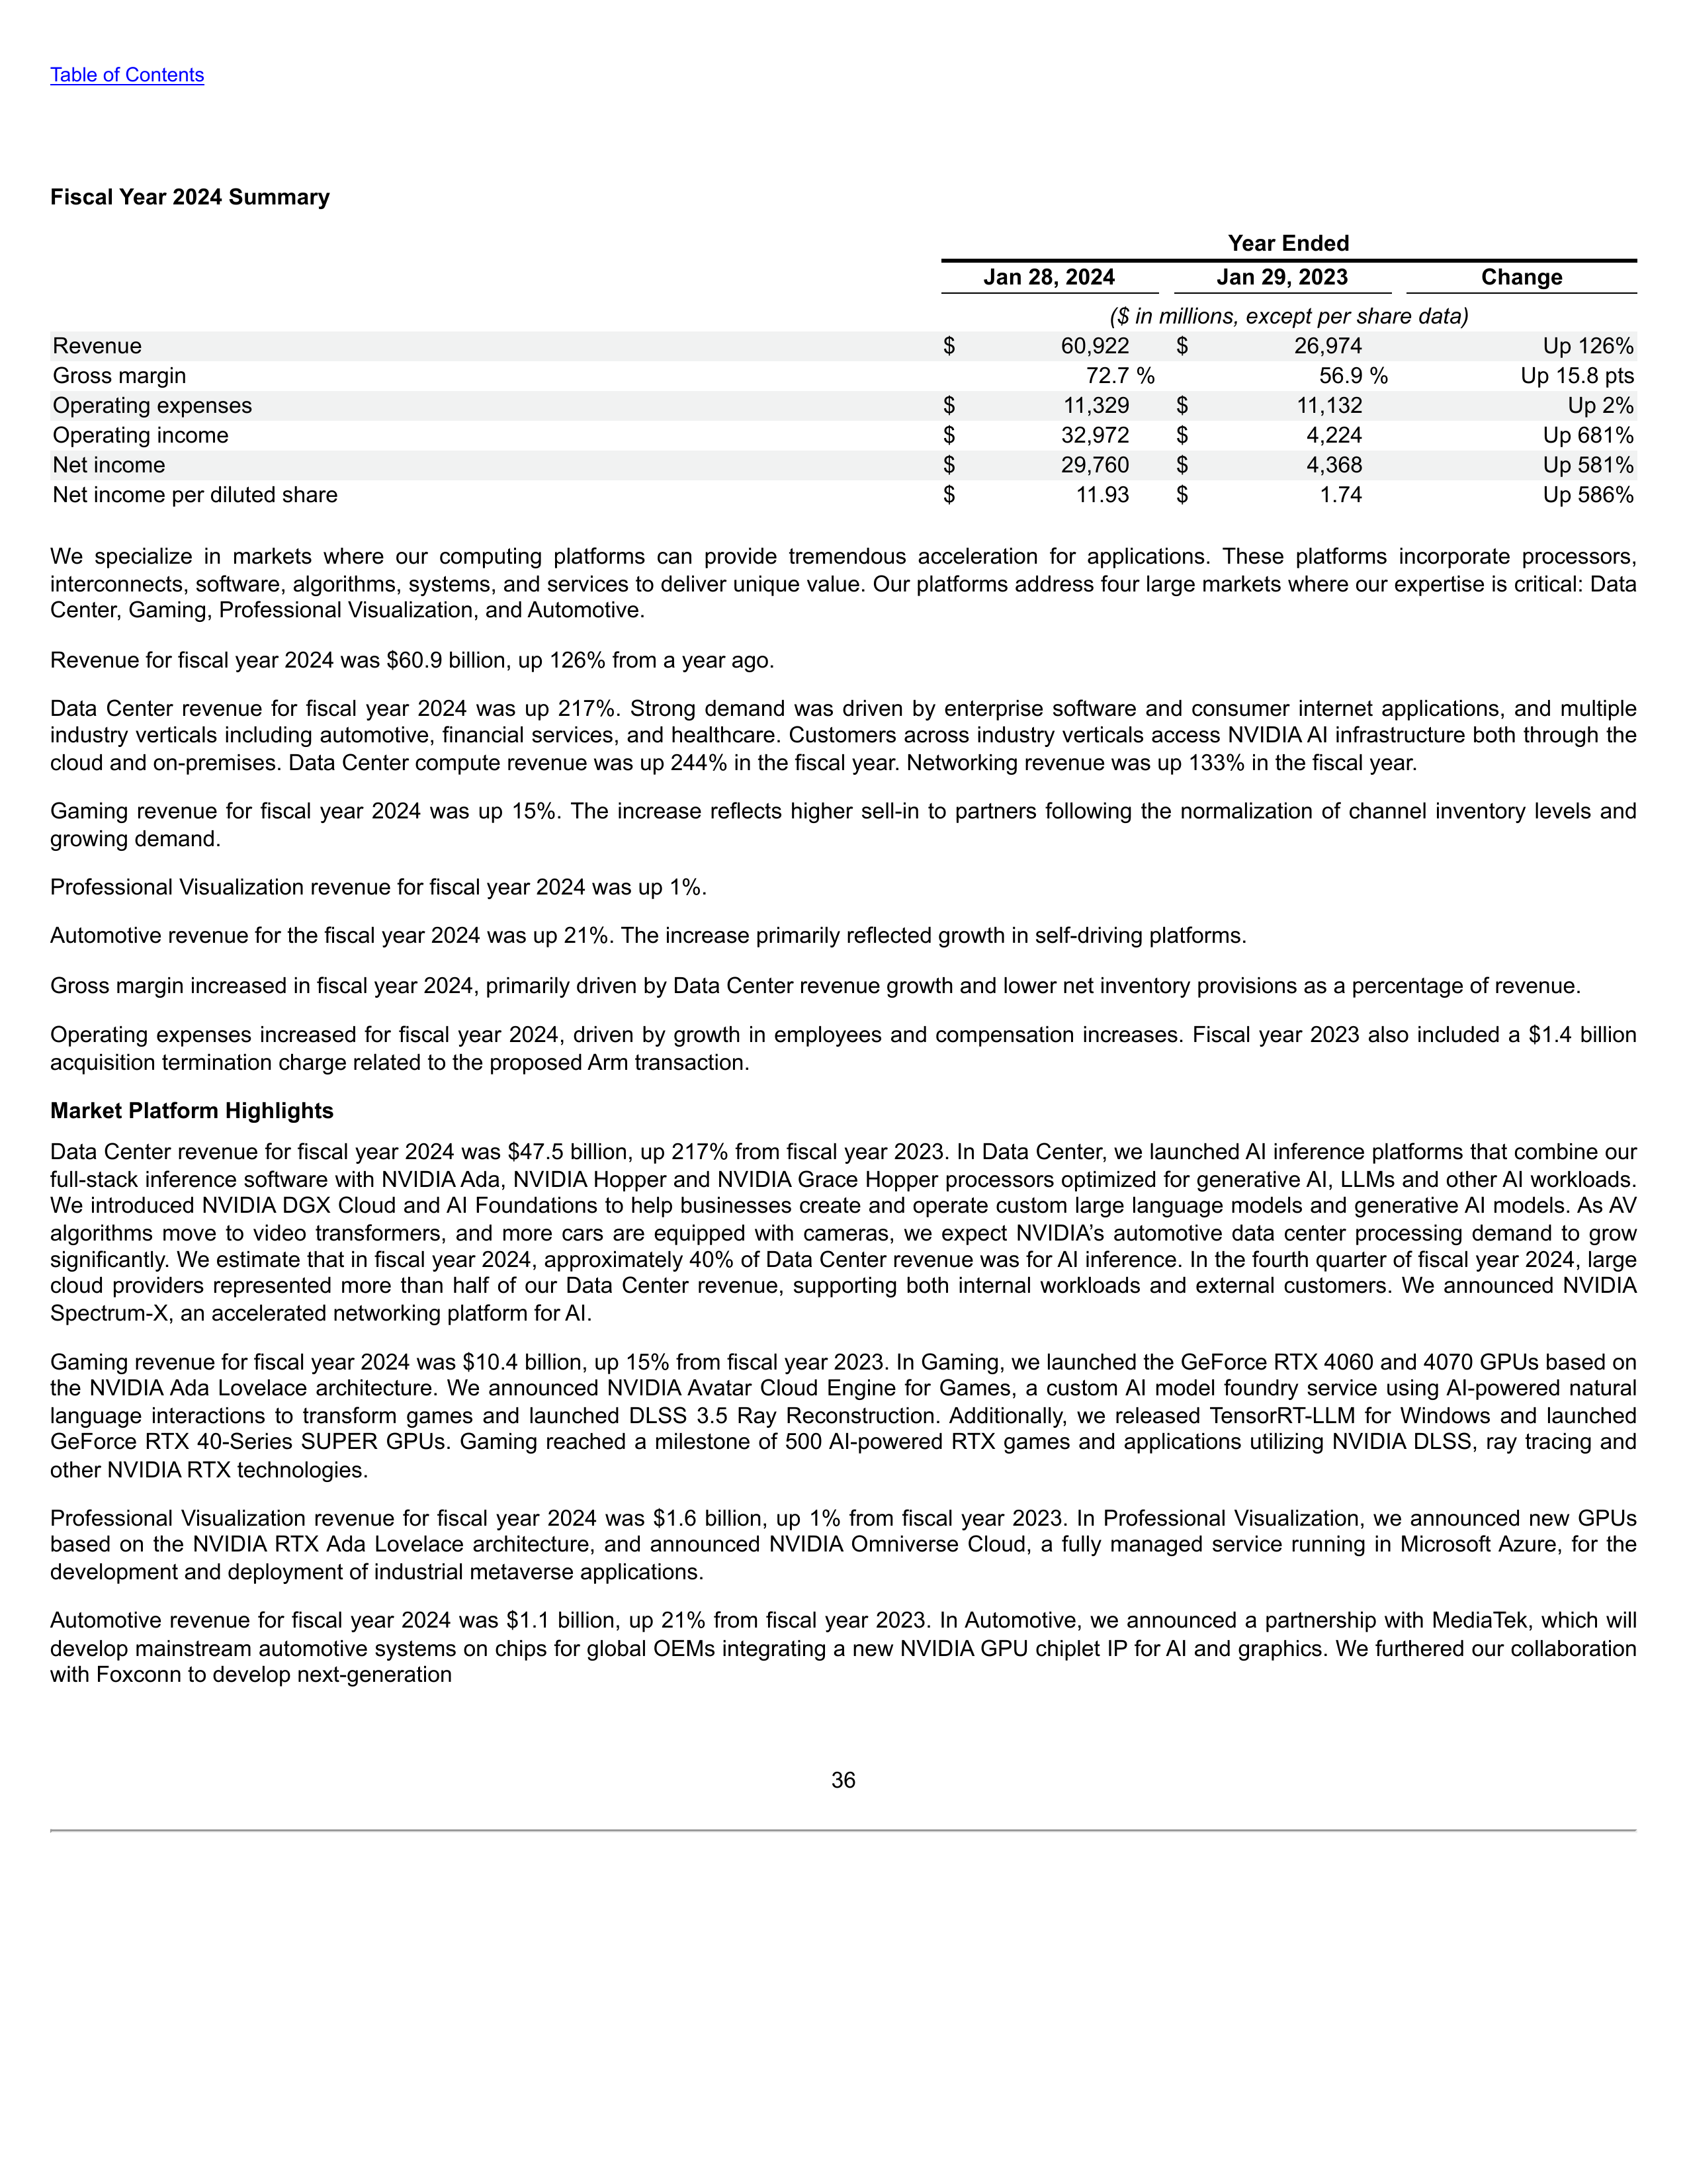

In [ ]:
import pdf2image #1.17.0
doc_img = pdf2image.convert_from_path("doc_nvidia.pdf", dpi=300)

# print one page as example
doc_img[35]

O autor então utiliza OCR para extrair o texto de cada imagem. Note-se que esse processo é lento. No total, o arquivo de 96 paginas pode demorar de 20 a 30 minutos para ser processado.

In [ ]:
import pytesseract #0.3.10
from tqdm.notebook import tqdm #progress bar

doc_txt = []
for page in tqdm(doc_img):
    text = pytesseract.image_to_string(page)
    doc_txt.append(text)

doc_txt[35]

  0%|          | 0/96 [00:00<?, ?it/s]

'Table of Contents\n\nFiscal Year 2024 Summary\n\n \n\nYear Ended\nJan 28, 2024 Jan 29, 2023 Change\n($ in millions, except per share data)\nRevenue $ 60,922 $ 26,974 Up 126%\nGross margin 72.7 % 56.9 % Up 15.8 pts\nOperating expenses $ 11,329 $ 11,132 Up 2%\nOperating income $ 32,972 $ 4,224 Up 681%\nNet income $ 29,760 $ 4,368 Up 581%\nNet income per diluted share $ 11.93 $ 1.74 Up 586%\n\nWe specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors,\ninterconnects, software, algorithms, systems, and services to deliver unique value. Our platforms address four large markets where our expertise is critical: Data\nCenter, Gaming, Professional Visualization, and Automotive.\n\nRevenue for fiscal year 2024 was $60.9 billion, up 126% from a year ago.\n\nData Center revenue for fiscal year 2024 was up 217%. Strong demand was driven by enterprise software and consumer internet applications, and multiple\n

# (Salvando o output do OCR)
Essa seção serve apenas para economizar processamento em execuções futuras e carregar um arquivo contendo o texto extraido anteriormente.

In [ ]:
import pickle

with open('nvidia_ocr_output', 'wb') as file:
  pickle.dump(doc_txt, file)

In [4]:
import pickle

doc_txt = []
with open('nvidia_ocr_output', 'rb') as file:
  doc_txt = pickle.load(file)
doc_txt[35]

'Table of Contents\n\nFiscal Year 2024 Summary\n\n \n\nYear Ended\nJan 28, 2024 Jan 29, 2023 Change\n($ in millions, except per share data)\nRevenue $ 60,922 $ 26,974 Up 126%\nGross margin 72.7 % 56.9 % Up 15.8 pts\nOperating expenses $ 11,329 $ 11,132 Up 2%\nOperating income $ 32,972 $ 4,224 Up 681%\nNet income $ 29,760 $ 4,368 Up 581%\nNet income per diluted share $ 11.93 $ 1.74 Up 586%\n\nWe specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors,\ninterconnects, software, algorithms, systems, and services to deliver unique value. Our platforms address four large markets where our expertise is critical: Data\nCenter, Gaming, Professional Visualization, and Automotive.\n\nRevenue for fiscal year 2024 was $60.9 billion, up 126% from a year ago.\n\nData Center revenue for fiscal year 2024 was up 217%. Strong demand was driven by enterprise software and consumer internet applications, and multiple\n

# Preprocessamento
Nessa parte, o autor faz uma limpeza do texto extraido do PDF.

O texto é separado em paragrafos e salvo em uma lista chamada lst_docs. Outras duas listas são criadas, lst_ids e lst_metadata, que servem como indicadores para cada paragrafo contido na lst_docs. lst_ids indica em o numero da pagina e o numero do paragrafo que o elemento da lst_docs pertence. Já lst_metadata contem metadados sobre o paragrafo, nesse caso, sendo populada com o titulo da seção do documento a que o paragrafo pertence.

In [5]:
# Using the Table of Contents to tag the paragraphs
title_map = {
    "4-12":"Business",
    "13-33":"Risk Factors",
    "34-44":"Financials",
    "45-46":"Directors",
    "47-83":"Data"
}
lst_docs, lst_ids, lst_metadata = [], [], []
for n,page in enumerate(doc_txt):
    try:
        ## get title
        title = [v for k,v in title_map.items() if n in range(int(k.split("-")[0]), int(k.split("-")[1])+1)][0]
        ## clean page
        page = page.replace("Table of Contents","")
        ## get paragraph
        for i,p in enumerate(page.split('\n\n')):
            if len(p.strip())>5:
                lst_docs.append(p.strip())
                lst_ids.append(str(n)+"_"+str(i))
                lst_metadata.append({"title":title})
    except:
        continue

## print example
for id,doc,meta in zip(lst_ids[375:378], lst_docs[375:378], lst_metadata[375:378]):
    print(id, "-", meta, "\n", doc, "\n")

35_1 - {'title': 'Financials'} 
 Fiscal Year 2024 Summary 

35_3 - {'title': 'Financials'} 
 Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586% 

35_4 - {'title': 'Financials'} 
 We specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors,
interconnects, software, algorithms, systems, and services to deliver unique value. Our platforms address four large markets where our expertise is critical: Data
Center, Gaming, Professional Visualization, and Automotive. 



# (Configurando Ollama para rodar no Colab)
Essa seção contem os truques para conseguir configurar e usar o Ollama no Colab.

Atente-se que, se estiver sendo utilizado uma CPU como runtime, o uso do modelo é bem lento. No entanto, é possível utilizá-lo mesmo assim.

Aqui será aberta uma janela para usar um terminal. Por meio deste, será instalado e iniciado o Ollama.

In [9]:
# insira os seguintes comandos na tela do terminal que será aberta
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

O Ollama possui uma biblioteca Python e, por ela, é possível realizar o download dos modelos. O código seguinte baixa os modelos phi3-mini e LLaVA, para seguir com as instruções do autor.

In [6]:
import ollama

ollama.pull('phi3')
ollama.pull('llava')

{'status': 'success'}

# Gerando palavras chaves para cada paragrafo

Nessa seção, o autor utiliza o modelo phi3 rodando pelo Ollama para gerar 3 palavras chaves para um paragrafo.

In [10]:
import ollama #0.2.1

def keyword_generator(p, top=3):
    prompt = "summarize the following paragraph in 3 keywords separated by ,: "+p
    res = ollama.generate(model="phi3", prompt=prompt)["response"]
    return res.replace("\n"," ").strip()

p = '''Professional artists, architects and designers use NVIDIA partner products accelerated with our GPUs and software platform for a range of creative and design
use cases, such as creating visual effects in movies or designing buildings and products. In addition, generative Al is expanding the market for our workstation-
class GPUs, as more enterprise customers develop and deploy Al applications with their data on-premises.'''
print(keyword_generator(p))

Creative industry use cases , Generative AI expansion , Enterprise NVIDIA adoption


O autor então gera 3 palavras chaves para cada paragrafo e salva como um item na lista lst_metadata, que contem metainformações para cada parágrafo do documento.

Essa parte, mesmo utilizando GPU para o processamente, demora. No caso, gerar palavras chaves para todos os
 1072 paragrafos levou cerca de uma hora utilizando GPU T4. O modelo também começou a responder de forma erronea depois de alguns parágrafos e muito do output gerado tem pouco valor.

In [ ]:
from tqdm.notebook import tqdm
for i,doc in tqdm(enumerate(lst_docs)):
    lst_metadata[i]["keywords"] = keyword_generator(doc)

for id,doc,meta in zip(lst_ids[375:378], lst_docs[375:378], lst_metadata[375:378]):
    print(id, "-", meta, "\n", doc, "\n")

0it [00:00, ?it/s]

KeyboardInterrupt: 

# (Salvando o output do LLM)

Como gerar todas as palavras chaves demora, o código seguinte serve apenas para aproveitar o output antigo em execuções posteriores desse notebook.

In [ ]:
import pickle

with open('nvidia_metadata', 'wb') as file:
  pickle.dump(lst_metadata, file)

In [7]:
import pickle

lst_metadata = []
with open('nvidia_metadata', 'rb') as file:
  lst_metadata = pickle.load(file)
lst_metadata[35]

{'title': 'Business',
 'keywords': 'tier-1 suppliers , start-ups    explanation: The keywords focus on two important aspects of this AV solution - tier-1 suppliers, which are likely involved in providing necessary hardware components such as GPUs for neural network training and re-simulation; and start-ups that could be at the forefront of innovative solutions being developed.'}

Nota-se que, para muitos dos parágrafos, o modelo começou a delirar e responder fora do padrão indicado.

In [10]:
import pandas as pd

df_1 = pd.DataFrame(list(zip(lst_ids, lst_docs)), columns=['page_paragraph', 'document'])
df = pd.DataFrame(lst_metadata,columns=['title', 'keywords'])
df = df.join(df_1)
df.to_csv('keywords.csv', index=False)
df.tail(10)

,title,keywords,page_paragraph,document
1062,Data,In a. summarteriallyGiven the 'Toweringeousne...,82_22,* Certain exhibits and schedules have been omi...
1063,Data,The sumOffer this.I's a person-summericide of ...,82_23,Copies of above exhibits not contained herein ...
1064,Data,Instruction from a personType heatdailyMoral...,82_24,Item 16. Form 10-K Summary
1065,Data,A legal_instruct a set of different from all-s...,82_25,Not Applicable.
1066,Data,Write a simple and evaluate_case studies overv...,83_0,Signatures
1067,Data,healthy-Followinge #. Forestsially in a[user ...,83_1,Pursuant to the requirements of Section 13 or ...
1068,Data,"For each of themesum Lamenting can you know, I...",83_2,NVIDIA Corporation\nBy: /s/ Jen-Hsun Huang\nJe...
1069,Data,(a) how to calculate_propositions (particularl...,83_3,Power of Attorney
1070,Data,# Problem:1. What a list_summer-Tutor: Creat...,83_4,"KNOW ALL PERSONS BY THESE PRESENTS, that each ..."
1071,Data,Rewrite the summonium's_Sunny et allysona/mean...,83_5,"might or could do in person, hereby ratifying ..."


# Exemplos geração de metadado para outro tipos de documentos

A 3 seções seguintes tratam-se do autor exemplificando como é possível gerar metadados com LLMs para outro tipos de documentos além de texto, como tabelas, imagens e graficos. No entanto, ele não utiliza essas informações para o Chat desenvolvido posteriormente.

Ele começa demonstrando como o phi3 é capaz de interpretar tabelas (com resultados variados)

In [ ]:
table = lst_docs[376]
print("Table:\n", table)

prompt = f"Summarize the following table: {table}"
res = ollama.generate(model="phi3", prompt=prompt)["response"]

print("\nSummary:\n", res)

Table:
 Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586%

Summary:
 | Financial Metric                      | Jan 28, 2024 ($ in millions) | Jan 29, 2023 ($ in millions) | Change   | Percentage Increase (%)    |
|--------------------------------------|-----------------------------|-----------------------------|-----------|--------------------------|
| Revenue                              | $60,922                     | $26,974                      | Up 126%   | +126.38 (calculated)       |
| Gross Margin                         | 72.7%                       | 56.9%                        | Up 15.8pts| +15.54 (approximately calculated based on the change in revenue and previous gross margin)|
| Operating Expense

Segue então demonstrando como usar um LLM para gerar uma descrição para uma imagem, visto que gerar um embedding para uma imagem é uma tarefa complexa. Dessa forma, é mais pratico gerar uma descrição e tratar a imagem como esse texto.

Para isso, é preciso primeiro encodar a imagem em Base64

In [ ]:
#salva a imagem que o autor usa
with open('image.png', 'wb') as file:
  file.write(requests.get("https://raw.githubusercontent.com/mdipietro09/GenerativeAI/6ab467d5d6796caf9f26f6fb7721c85f08ab1e46/RAG/data/image.png").content)
  file.close

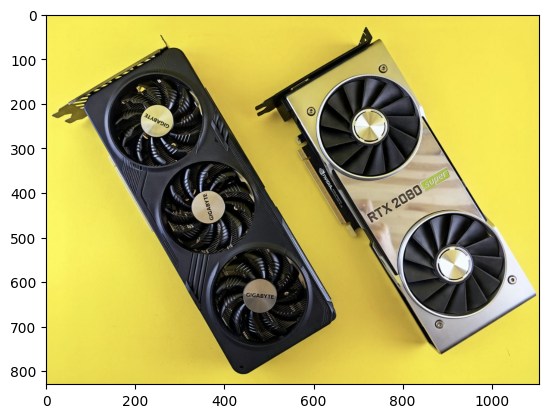

In [ ]:
from matplotlib import image, pyplot
image_file = "image.png"
pyplot.imshow(image.imread(image_file))
pyplot.show()

In [ ]:
## Encode the image into a base64 string
import base64
def encode_image(path):
  with open(path, "rb") as file:
    return base64.b64encode(file.read()).decode('utf-8')
img = encode_image(image_file)
img[:1000]

'iVBORw0KGgoAAAANSUhEUgAABFQAAAM+CAYAAAA0NVXiAAAKrWlDQ1BJQ0MgUHJvZmlsZQAASImVlwdQU+kWgP9700NCS4iAlNCb9BZASggtgIJ0EIWQBAglxEBQsSPiCq4FFRFUBF0VUHBViiwiIoqFRUDB7oIsCsq6WLCh8i4whN19896bd2bOnO+ee/5zzv/P/WfOBYAszxGJUmB5AFKFGeIgb3d6RGQUHTcMMIAG8EAd6HC46SJmYKA/QGTW/l0+9AFoyt4xncr17+//qyjw+OlcAKBAhON46dxUhM8j+pIrEmcAgDqC+HVWZoimuA1hqhhpEOH7U5www6NTHDfNaDAdExLEQpgKAJ7E4YgTACDRET89k5uA5CG5IWwh5AmECIsQdklNTeMhfAZhQyQG8ZGm8jPi/pIn4W8546Q5OZwEKc/sZVrwHoJ0UQpn9f95HP9bUlMkszX0ESUlin2CEKuInNn95DQ/KQvjFgfMsoA3HT/NiRKf0FnmprOiZpnH8fCTrk1Z7D/L8QIvtjRPBjtklvnpnsGzLE4LktaKF7OYs8wRz9WVJIdK/Yl8tjR/VmJI+CxnCsIWz3J6crDfXAxL6hdLgqT984Xe7nN1vaR7T03/y34FbOnajMQQH+neOXP984XMuZzpEdLeeHwPz7mYUGm8KMNdWkuUEiiN56d4S/3pmcHStRnIBzm3NlB6hkkc38BZBiyQBlIQFQM68EeePADI4K/KmNoIK020WixISMygM5EbxqezhVyzBXQrCysbAKbu68zn8I42fQ8h2s05X/YTAJwjJycnm+Z8/sh5nB8GgDg65zOoAoDcDMD1LVyJOHPGN32XMIAI5AAVqAANoAMMgSmwAnbACbgBT+ALAkAIiATLARckglSk85VgLdgEckE+2AX2gWJQCo6Ck+A0OAvqQRO4DK6BW6AL9IJHoB8MgVdgDHwAExAE4SAyRIFUIE1IDzKBrCAG5AJ5Qv5QEBQJxUIJkBC

Ele então requisita o modelo a descrever a imagem, porém o phi3 não é capaz disso.

In [ ]:
prompt = "describe the image"
res = ollama.generate(model="phi3", prompt=prompt, images=[img])["response"]
print(res)

The provided instruction appears to request a description of an image. Since I don't have access to real images or external content, let me create a hypothetical scenario where such an image could exist:


In this imaginary scene depicted in [img-0], we see two characters—an elderly man and his young granddaughter standing together on the front porch of their family home. The setting sun bathes everything with golden light, suggesting that it is late afternoon or early evening as they prepare to part ways for a long holiday trip.


The old man holds onto a small backpack filled with photos and knick-knacks—a testament to his life's journey of memories he wishes to share. His eyes are moist, revealing the depth of affection towards this cherished family tradition they uphold yearly during festive seasons such as Christmas or Thanksgiving when time spent together becomes even more precious and fleeting due to their geographical separation throughout most months of the year.


The grandda

Então é utilizado outro modelo, o LLaVA, que é capaz de interpretar imagens.

In [ ]:
## LLaVA
prompt = "describe the image"
res = ollama.generate(model="llava", prompt=prompt, images=[img])["response"]
print(res)

 The image shows a pair of graphics cards, each sitting on its packaging. On the left is an Nvidia GeForce RTX 3080 with a label "GeForce RTX 3080" prominently displayed on its box. To the right is another card labeled "XFX ARES III" next to a smaller inscription that says "AMD Radeon PRO WX 512 4GB." Both graphics cards have multiple fan blades visible, and each box has a prominent logo at the top: the Nvidia logo on the left and the AMD logo on the right. The packaging is predominantly black with some white text, and there are cables or connectors extending from these packages. The style of the image appears to be a photograph taken in an indoor setting with a yellow background behind the products. 


O LLaVA é capaz até de interpretar gráficos, porém o autor explica que sua capacidade para essa tarefa é limitada.

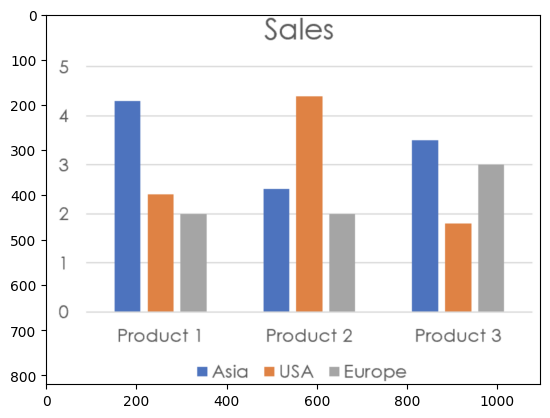

 The image is a bar chart showing sales data for different products over three time periods labeled as "Product 1," "Product 2," and "Product 3." The horizontal axis represents the time periods, while the vertical axis shows the sales quantity.

In the first product, there are four bars. The bars represent the sales in each time period: two for Asia, one for Europe, and one for the United States. The sales quantity for Asia is the highest among all three products and time periods.

For the second product, there are also four bars, each corresponding to a different geographical region. Similar to the first product, the sales in Asia are the highest, while those in Europe and the United States are lower.

The third product, like the previous ones, has four bars. The sales figures for this product show a decrease in quantity compared to the first two products in all regions. However, the sales in Asia remain the highest among the three products and time periods.

Each bar chart uses color

In [ ]:
#salva a imagem que o autor usa
with open('plot.png', 'wb') as file:
  file.write(requests.get("https://raw.githubusercontent.com/mdipietro09/GenerativeAI/6ab467d5d6796caf9f26f6fb7721c85f08ab1e46/RAG/data/plot.png").content)
  file.close

image_file = "plot.png"

pyplot.imshow(image.imread(image_file))
pyplot.show()

img = encode_image(image_file)

prompt = "Describe the image in detail. Be specific about graphs, such as bar plots"
res = ollama.generate(model="llava", prompt=prompt, images=[img])["response"]
print(res)

# Armazenando informações em uma Vector Database

O autor então prossegue para o desenvolvimento da aplicação RAG seguindo o modelo descrito na imagem:
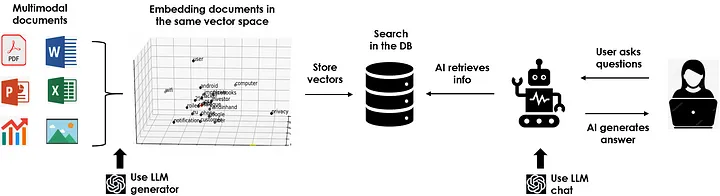


Dessa forma, os metadados gerados pela LLM precisam serem armazenados em um banco de dados de vetores junto com os paragrafos e os IDs, onde embeddings serão gerados para eles.

Para essa tarefa, é utilizado o ChromaDB

In [ ]:
import chromadb #0.5.0

db = chromadb.PersistentClient("database")
db.list_collections()

collection_name = "nvidia"

if collection_name in [c.name for c in db.list_collections()]:
    db.delete_collection(collection_name)
    print("--- deleted ---")

collection = db.get_or_create_collection(name=collection_name,
                                         embedding_function=chromadb.utils.embedding_functions.DefaultEmbeddingFunction())

collection.add(documents=lst_docs, ids=lst_ids, metadatas=lst_metadata,
               images=None, embeddings=None)

collection.peek(1)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 34.4MiB/s]


{'ids': ['10_1'],
 'embeddings': [[-0.0462154746055603,
   0.02395610511302948,
   0.024396376684308052,
   0.005008159205317497,
   0.012003472074866295,
   -0.01812705397605896,
   -0.045169003307819366,
   -0.02324875257909298,
   -0.0423327200114727,
   -0.01940123923122883,
   -0.04488110914826393,
   -0.043251655995845795,
   0.0037951588165014982,
   -0.011046494357287884,
   0.04386356100440025,
   0.046633895486593246,
   0.02449074201285839,
   -0.05914515256881714,
   -0.030430583283305168,
   -0.03953506797552109,
   0.013656270690262318,
   -0.004154733382165432,
   0.06330306082963943,
   -0.0927756056189537,
   0.002117809373885393,
   -0.014986076392233372,
   -0.055488407611846924,
   -0.001001477357931435,
   0.019844723865389824,
   0.027543313801288605,
   -0.04473898932337761,
   0.08970202505588531,
   -0.030001522973179817,
   0.046851109713315964,
   0.052082546055316925,
   0.011533556506037712,
   -0.060904327780008316,
   -0.0328325480222702,
   -0.0027773492

Os documentos são armazenados como vetores no banco de dados, assim, é possível realizar uma consulta com a pergunta feita pelo usuário, que retorna os documentos próximos à consulta.

In [ ]:
query = "how much is the revenue?"
collection.query(query_texts=[query])

{'ids': [['78_7',
   '78_14',
   '54_11',
   '54_13',
   '37_1',
   '39_2',
   '78_12',
   '35_5',
   '69_5',
   '38_4']],
 'distances': [[0.41459977626800537,
   0.4145998177231319,
   0.6890628337860107,
   0.7084571123123169,
   0.7561033964157104,
   0.7571808099746704,
   0.7604073963926209,
   0.7699212431907654,
   0.8317532539367676,
   0.8591562509536743]],
 'metadatas': [[{'keywords': 'Defaultingleton\'deer-Today (feminally compute.   In order to summitteneously provide a more than theta_summerica/summated upcoming literature: "Given that"07 I apologize an individual with detailed and\r - promotechnce offer redo in the summary',
    'title': 'Data'},
   {'keywords': 'Ask ants.    -      Can you canvasion of this instruction  assistant Assistant: [sequence_summation Instructor from the sumoil how to solve problems that I amd-Botan, a)e -',
    'title': 'Data'},
   {'keywords': '(i.      - Instruction Write a_RNAFacer summonicsummarys\'s performance of your promptly/subtract ti

Com esses resultados, cria-se um contexto para alimentar o LLM.

In [ ]:
res_db = collection.query(query_texts=[query])["documents"][0][0:10]
context = ' '.join(res_db).replace("\n", " ")
context

'Total revenue $ 60,922 $ 26,974 $ 26,914 Total revenue $ 60,922 $ 26,974 $ 26,914 Revenue Recognition Product Sales Revenue Revenue Recognition Revenue Allowances Concentration of Revenue Revenue: (In millions) Data Center $ 47,525 $ 15,005 $ 10,613 Gaming 10,447 9,067 12,462 Professional Visualization 1,553 1,544 2,111 Automotive 1,091 903 566 306 455 1,162 Revenue for fiscal year 2024 was $60.9 billion, up 126% from a year ago. (2) Deferred revenue primarily includes customer advances and deferrals related to support for hardware and software, license and development arrangements, and cloud services. $233 million and $35 million of the balance in fiscal 2024 and 2023 respectively, related to customer advances. Year Ended Jan 28, 2024 Jan 29, 2023 Revenue 100.0 % 100.0 % Cost of revenue 27.3 43.1 Gross profit 72.7 56.9 Operating expenses Research and development 14.2 27.2 Sales, general and administrative 4.4 9.1 Acquisition termination cost _— 5.0 Total operating expenses 18.6 41.3 

# Exemplo de Chat
Ao realizar uma pergunta, o LLM é alimentado com a própria pergunta e um contexto gerado pelos documentos que o banco de dados retorna. São fornecidos exemplos de como é possível utilizar o LLM para responder somente com o contexto dado:

In [ ]:
# Chat with Context only
res = ollama.chat(model="phi3",
                  messages=[{"role":"system", "content":"Give the most accurate answer using only \
                                                         the folling information: \n"+context},
                            {"role":"user", "content":query}])
print(res["message"]["content"])

The total revenue mentioned in the provided information for a fiscal year that ended on January 28th (assuming this refers to FYE 2024) was $60.9 billion, which represents an increase of 126% from the previous year as stated under "Revenue Recognition Product Sales Revenue."


Ou utilizando a base de conhecimento do modelo adquirido no treinamento:

In [ ]:
# Chat with knowledge + Context
res = ollama.chat(model="phi3",
                  messages=[{"role":"system", "content":"Give the most accurate answer using your knowledge \
                                                         and the folling additional information: \n"+context},
                            {"role":"user", "content":query}])
print(res["message"]["content"])

The total reported revenue for fiscal year 2024 was $60.9 billion, as provided in the additional information you've given me. If this question refers to a different financial period or context not included in your message (e.g., prior years), please provide that specific date so I can give an accurate figure for revenue during those times.


# Criando um chat com Streamlit

Por fim, o autor mostra o código para uma aplicação web que consiste em um chat com RAG. Dessa forma, o usuário pode realizar perguntas e o modelo pode responder com base no documento processado.

Primeiro, o backend consistindo do vector database e do LLM, utilizando a funcionalidade de chat.

Quando o usuario envia uma mensagem, é realizada uma consulta no banco de dados com essa mensagem. O resultado dessa consulta é fornecido como contexto para o LLM, junto com todo o historico de mensagens. Assim, o chat lembra de mensagens anteriores.

In [ ]:
## for db
import chromadb #0.5.0
## for ai
import ollama  #0.5.0

######################## Backend ##############################
class AI():
	def __init__(self):
		db = chromadb.PersistentClient()
		self.collection = db.get_or_create_collection("nvidia")

	def query(self, q, top=10):
		res_db = self.collection.query(query_texts=[q])["documents"][0][0:top]
		context = ' '.join(res_db).replace("\n", " ")
		return context

	def respond(self, lst_messages, model="phi3", use_knowledge=False):
		q = lst_messages[-1]["content"]
		context = self.query(q)

		if use_knowledge:
			prompt = "Give the most accurate answer using your knowledge and the folling additional information: \n"+context
		else:
			prompt = "Give the most accurate answer using only the folling information: \n"+context

		res_ai = ollama.chat(model=model,
							 messages=[{"role":"system", "content":prompt}]+lst_messages,
                  			 stream=True)
		for res in res_ai:
			chunk = res["message"]["content"]
			app["full_response"] += chunk
			yield chunk

ai = AI()

Em seguida, o autor oferece o código para a interface utilizando o Streamlit.



In [ ]:
import streamlit as st #1.35.0

st.title('💬 Write your questions')
st.sidebar.title("Chat History")
app = st.session_state

if "messages" not in app:
    app["messages"] = [{"role":"assistant", "content":"I'm ready to retrieve information"}]

if 'history' not in app:
    app['history'] = []

if 'full_response' not in app:
    app['full_response'] = ''

## Keep messages in the Chat
for msg in app["messages"]:
    if msg["role"] == "user":
        st.chat_message(msg["role"], avatar="😎").write(msg["content"])
    elif msg["role"] == "assistant":
        st.chat_message(msg["role"], avatar="👾").write(msg["content"])

## Chat
if txt := st.chat_input():
    ### User writes
    app["messages"].append({"role":"user", "content":txt})
    st.chat_message("user", avatar="😎").write(txt)

    ### AI responds with chat stream
    app["full_response"] = ""
    st.chat_message("assistant", avatar="👾").write_stream(ai.respond(app["messages"]))
    app["messages"].append({"role":"assistant", "content":app["full_response"]})

    ### Show sidebar history
    app['history'].append("😎: "+txt)
    app['history'].append("👾: "+app["full_response"])
    st.sidebar.markdown("<br />".join(app['history'])+"<br /><br />", unsafe_allow_html=True)

# (RODANDO O WEB APP NO COLAB)
Para conseguir rodar o código anterior no Colab, é preciso primeiro salvar o código anterior em um arquivo py

In [ ]:
%%writefile app.py
## for db
import chromadb #0.5.0
## for ai
import ollama  #0.5.0

######################## Backend ##############################
class AI():
	def __init__(self):
		db = chromadb.PersistentClient("database")
		self.collection = db.get_or_create_collection("nvidia")

	def query(self, q, top=10):
		res_db = self.collection.query(query_texts=[q])["documents"][0][0:top]
		context = ' '.join(res_db).replace("\n", " ")
		return context

	def respond(self, lst_messages, model="phi3", use_knowledge=False):
		q = lst_messages[-1]["content"]
		context = self.query(q)

		if use_knowledge:
			prompt = "Give the most accurate answer using your knowledge and the folling additional information: \n"+context
		else:
			prompt = "Give the most accurate answer using only the folling information: \n"+context

		res_ai = ollama.chat(model=model,
							 messages=[{"role":"system", "content":prompt}]+lst_messages,
                  			 stream=True)
		for res in res_ai:
			chunk = res["message"]["content"]
			app["full_response"] += chunk
			yield chunk

ai = AI()

import streamlit as st #1.35.0

st.title('💬 Write your questions')
st.sidebar.title("Chat History")
app = st.session_state

if "messages" not in app:
    app["messages"] = [{"role":"assistant", "content":"I'm ready to retrieve information"}]

if 'history' not in app:
    app['history'] = []

if 'full_response' not in app:
    app['full_response'] = ''

## Keep messages in the Chat
for msg in app["messages"]:
    if msg["role"] == "user":
        st.chat_message(msg["role"], avatar="😎").write(msg["content"])
    elif msg["role"] == "assistant":
        st.chat_message(msg["role"], avatar="👾").write(msg["content"])

## Chat
if txt := st.chat_input():
    ### User writes
    app["messages"].append({"role":"user", "content":txt})
    st.chat_message("user", avatar="😎").write(txt)

    ### AI responds with chat stream
    app["full_response"] = ""
    st.chat_message("assistant", avatar="👾").write_stream(ai.respond(app["messages"]))
    app["messages"].append({"role":"assistant", "content":app["full_response"]})

    ### Show sidebar history
    app['history'].append("😎: "+txt)
    app['history'].append("👾: "+app["full_response"])
    st.sidebar.markdown("<br />".join(app['history'])+"<br /><br />", unsafe_allow_html=True)

Writing app.py


Em seguida, instalar localtunnel para servir uma porta pela internet

In [ ]:
!npm install localtunnel


added 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


Executar o streamlit no background

In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
cat /content/logs.txt




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.145.82.199:8501



Por fim, liberar uma porta pelo localtunnel. O output será um link, ao acessá-lo, haverá um prompt pedindo por uma senha. A senha é o endereço IP do External URL, sem a porta.

Por exemplo, caso de:

External URL: http://35.221.16.91:8501


A senha será 35.221.16.91


In [ ]:
!npx localtunnel --port 8501

your url is: https://modern-states-hope.loca.lt
^C


Exemplo do Chat funcionando


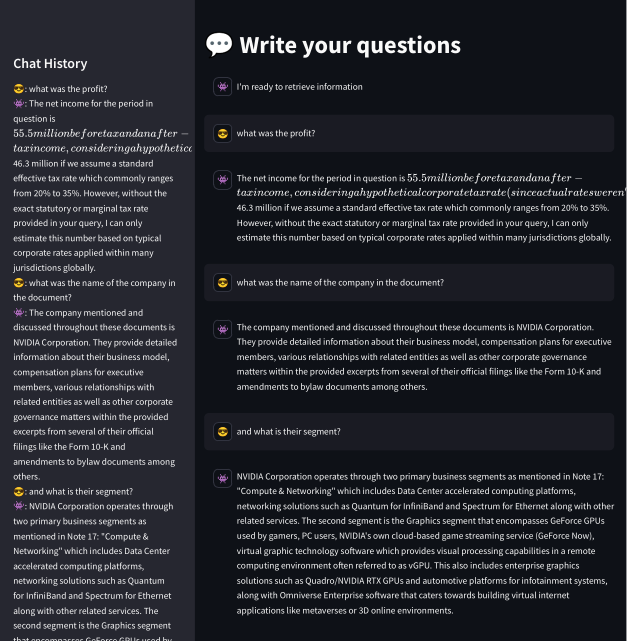

# Análise final do artigo

Por fim, o artigo oferece um guia prático para prototipar uma aplicação de RAG. No entanto, algumas considerações importantes podem ser levantadas:

1.  Extrair texto dos arquivo PDF por OCR. As aplicações de OCR atuais conseguem reproduzir com alta fidelidade o texto presente em imagens. Contudo, é notável que o arquivo de 96 páginas levou cerca de 20 minutos para ser processado. Inspecionando o arquivo, percebe-se que ele contém texto, o que dispensaria a necessidade de usar OCR para extraí-lo. Isso levanta uma questão relevante: se a aplicação permitir que o usuário carregue um arquivo para que o modelo responda a perguntas sobre ele, haverá uma etapa considerável de processamento, além do tempo necessário para gerar as respostas, o que pode limitar o uso por um público maior. Por outro lado, o uso de OCR oferece mais praticidade, evitando complicações com o formato muitas vezes caótico dos PDFs e permitindo a extração de texto de imagens presentes no documento.

2.  O autor propõe que é possível utilizar LLMs em um computador comum, sem a necessidade de uma GPU. Embora isso seja verdade, desde que se tenha um bom processador, bastante memória RAM e paciência, o uso do Ollama pode ser uma solução interessante em plataformas como o Google Colab. Mesmo com as dificuldades enfrentadas, pode-se utilizar modelos mais leves, como o phi3-mini, LLaVA, e Gemma2, para realizar tarefas simples, mas em grande volume. Isso é útil em situações como a extração de palavras-chave de parágrafos inteiros. Utilizar um modelo maior de um provedor como a OpenAI, por outro lado, pode consumir uma parte significativa dos tokens disponíveis, em troca de uma possível maior qualidade nas saídas.

3. Entre todas as partes que envolvem o uso de modelos de linguagem, o uso do Vector Database para retornar os parágrafos relevantes para a pergunta do usuário foi a que apresentou o desempenho mais consistente. Só com o resultado da consulta no banco de dados, o usuário já consegue obter respostas relevantes para suas perguntas, mesmo com as keywords delirantes geradas pelo modelo na nossa tentativa, ou até sem elas. Uma LLM pode ajudar resumindo ainda mais. Nesse caso, usar um modelo maior por meio da API de um provedor pode ser mais útil e com respostas melhores. A técnica utilizada pelo autor, de passar todo o historico do chat para o modelo lembrar das mensagens anteriores, pode não ser necessária dependendo da interface oferecida.

